# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

warnings.filterwarnings( 'ignore' )

C:\Users\Emanoel\anaconda3\envs\DS\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['data'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['data'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['data'] < validation_start_date]
        validation = x_training[(x_training['data'] >= validation_start_date) & (x_training['data'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['data', 'vendas'], axis=1 ) 
        ytraining = training['vendas']

        # validation
        xvalidation = validation.drop( ['data', 'vendas'], axis=1 )
        yvalidation = validation['vendas']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_train_raw = pd.read_csv('../DATA/train.csv' , low_memory=False)
df_store_raw = pd.read_csv('../DATA/store.csv' , low_memory=False)

# Merge
df_raw= pd.merge(df_train_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
894369,925,7,2013-04-21,0,0,0,0,0,0,c,a,470.0,3.0,2007.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0. DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [7]:
cols_old = ['Loja', 'DiaDaSemana', 'Data', 'Vendas', 'Clientes', 'Aberto', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Variedade',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old) )

# Rename
df1.columns = cols_new

## 1.2 Data dimensions 

In [8]:
print( 'Nubers of Rows: {}' .format( df1.shape[0] ) )
print( 'Nubers of Cols: {}' .format( df1.shape[1] ) )

Nubers of Rows: 1017209
Nubers of Cols: 18


## 1.3 Data types 

In [9]:
df1['data'] = pd.to_datetime( df1 [ 'data'] )

df1.dtypes

loja                                     int64
dia_da_semana                            int64
data                            datetime64[ns]
vendas                                   int64
clientes                                 int64
aberto                                   int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
variedade                               object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

loja                                 0
dia_da_semana                        0
data                                 0
vendas                               0
clientes                             0
aberto                               0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
variedade                            0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA 

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
    
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['data'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    
#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['data'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
    
#promo2_since_week         
df1['promo2_since_week'] = df1.apply( lambda x: x['data'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    
#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['data'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval             
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )
   
df1['month_map'] = df1['data'].dt.month.map( month_map )
 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
   

In [12]:
df1.isna().sum()

loja                            0
dia_da_semana                   0
data                            0
vendas                          0
clientes                        0
aberto                          0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
variedade                       0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descreptive statistics

In [14]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

## 1.7.1. Numerical Atributes

In [16]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,loja,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,dia_da_semana,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,vendas,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,clientes,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,aberto,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


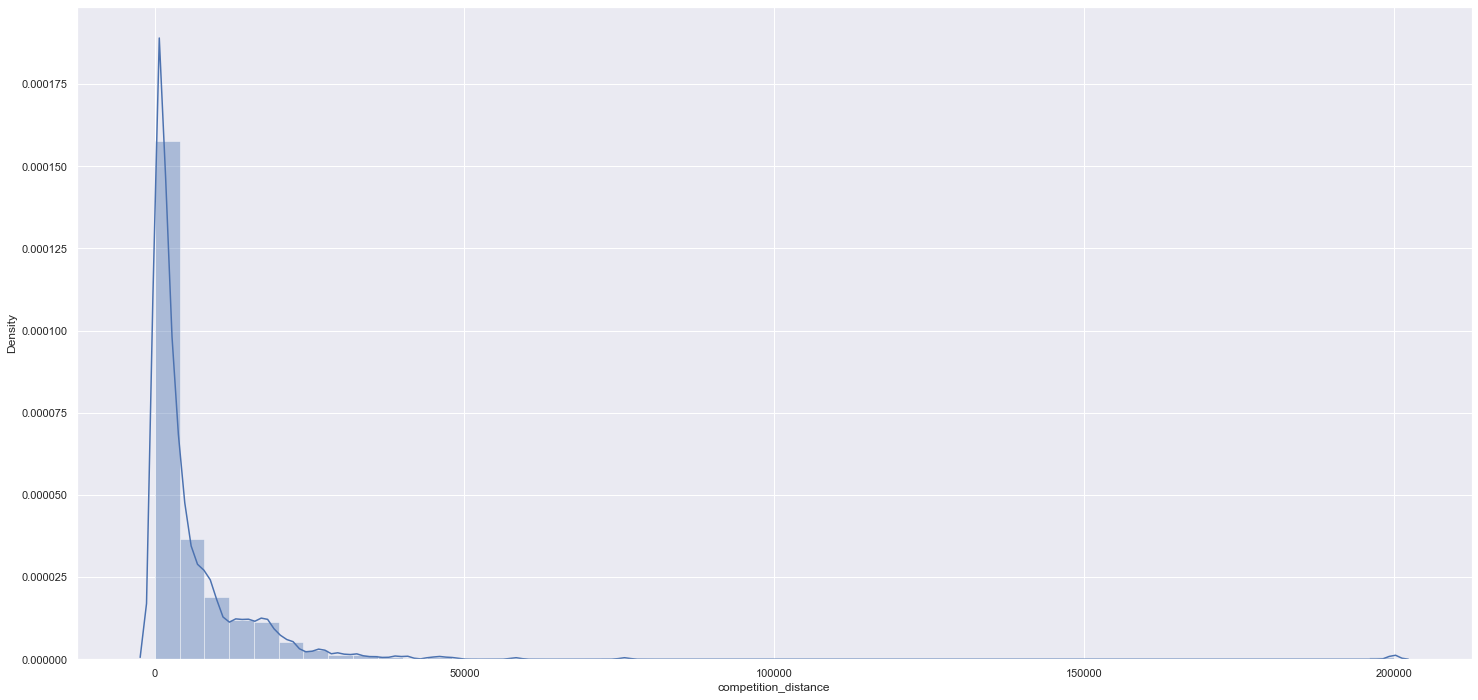

In [18]:
sns.distplot( df1['competition_distance'] );

## 1.7.2. Categorical Atributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
variedade                        3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

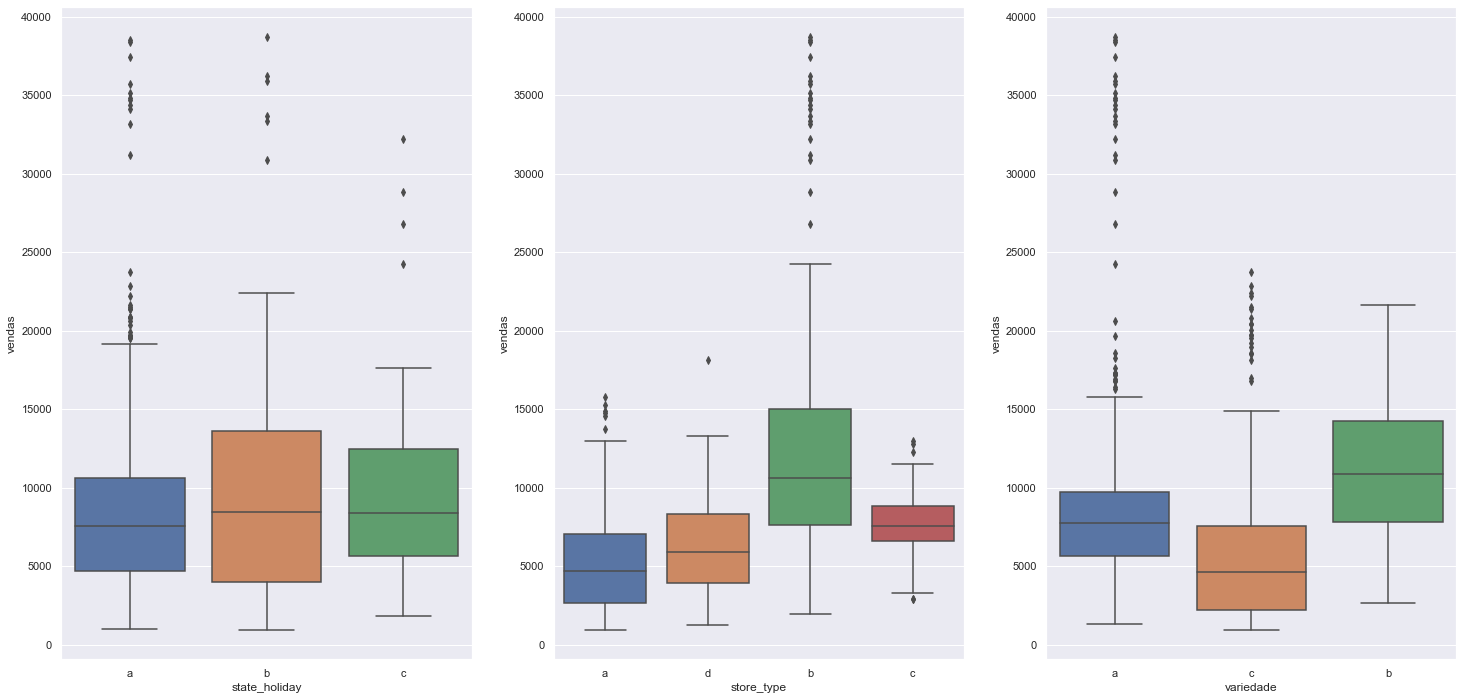

In [20]:
aux = df1[(df1['state_holiday'] != '0') & (df1['vendas'] > 0)]

plt.subplot( 1, 3, 1 );
sns.boxplot( x='state_holiday', y='vendas', data=aux );

plt.subplot( 1, 3, 2 );
sns.boxplot( x='store_type', y='vendas', data=aux );

plt.subplot( 1, 3, 3 );
sns.boxplot( x='variedade', y='vendas', data=aux );

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

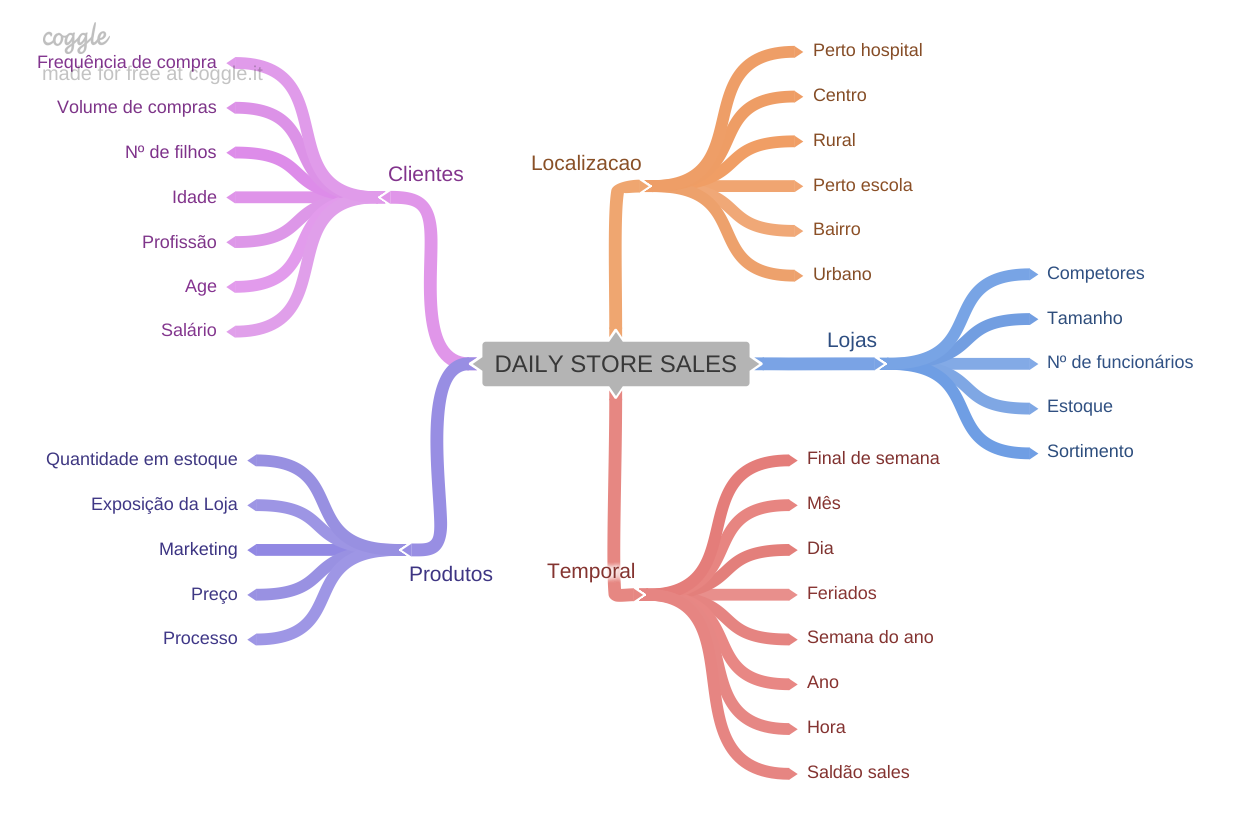

In [22]:
Image('../Img/mind_map.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com múmero maior de funcionários deveriam vender mais.

**2.** Lojas coom maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveiram vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto 

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos de menor preço deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.3.3 Hipóteses de Tempo 

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Lista final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**5.** Lojas com mais dias de promoção deveriam vender mais. 

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre. 

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

 **11.** Lojas deveriam vender menos finais de semana.
 
 **13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [23]:
# year
df2['year'] = df2['data'].dt.year
# month
df2['month'] = df2['data'].dt.month
# day
df2['day'] = df2['data'].dt.day
# week of year
df2['week_of_year'] = df2['data'].dt.weekofyear
# year week
df2['year_week'] = df2['data'].dt.strftime( '%Y-%W' )



# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(
year=x['competition_open_since_year'],
month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['data'] - df2['competition_since'] )/30).apply(
                                                        lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.
strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['data'] - df2['promo_since'] )/7 ).apply(
lambda x: x.days ).astype( int )



# Variedade
df2['variedade'] = df2['variedade'].apply( lambda x: 'basic' if x == 'a' else
'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'
if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'
else 'regular_day' )


# 3.0. FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head(1)

,loja,dia_da_semana,data,vendas,clientes,aberto,promo,state_holiday,school_holiday,store_type,variedade,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0


## 3.1 Filtragem das linhas

In [26]:
df3 = df3[ ( df3['aberto']!= 0 ) & ( df3 ['vendas'] > 0 ) ]

## 3.2 Seleção das colunas

In [27]:
cols_drop = [ 'clientes', 'aberto', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

In [28]:
df3.columns

Index(['loja', 'dia_da_semana', 'data', 'vendas', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'variedade', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0.  ANÁLISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1 Análise univariada 

### 4.1.1 Response varieble 

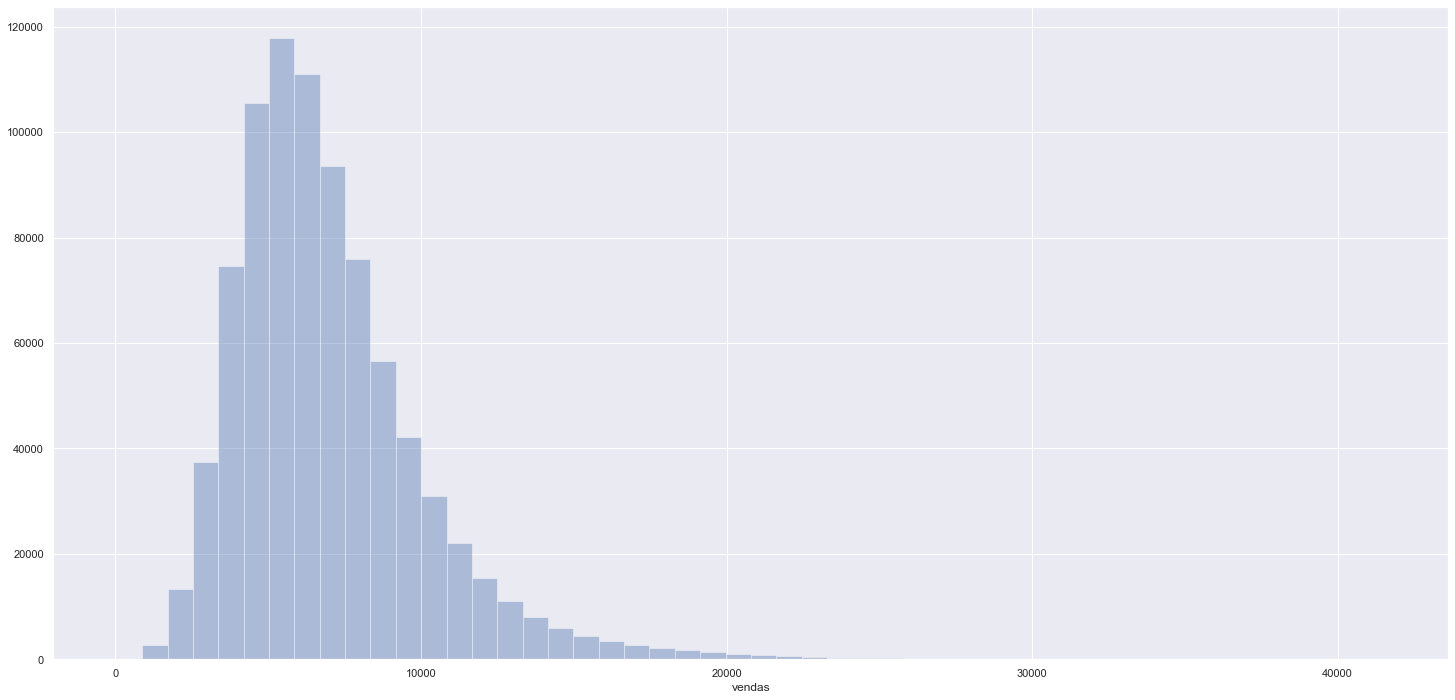

In [30]:
sns.distplot( df4 ['vendas'], kde =False );

### 4.1.2 Numerical variable

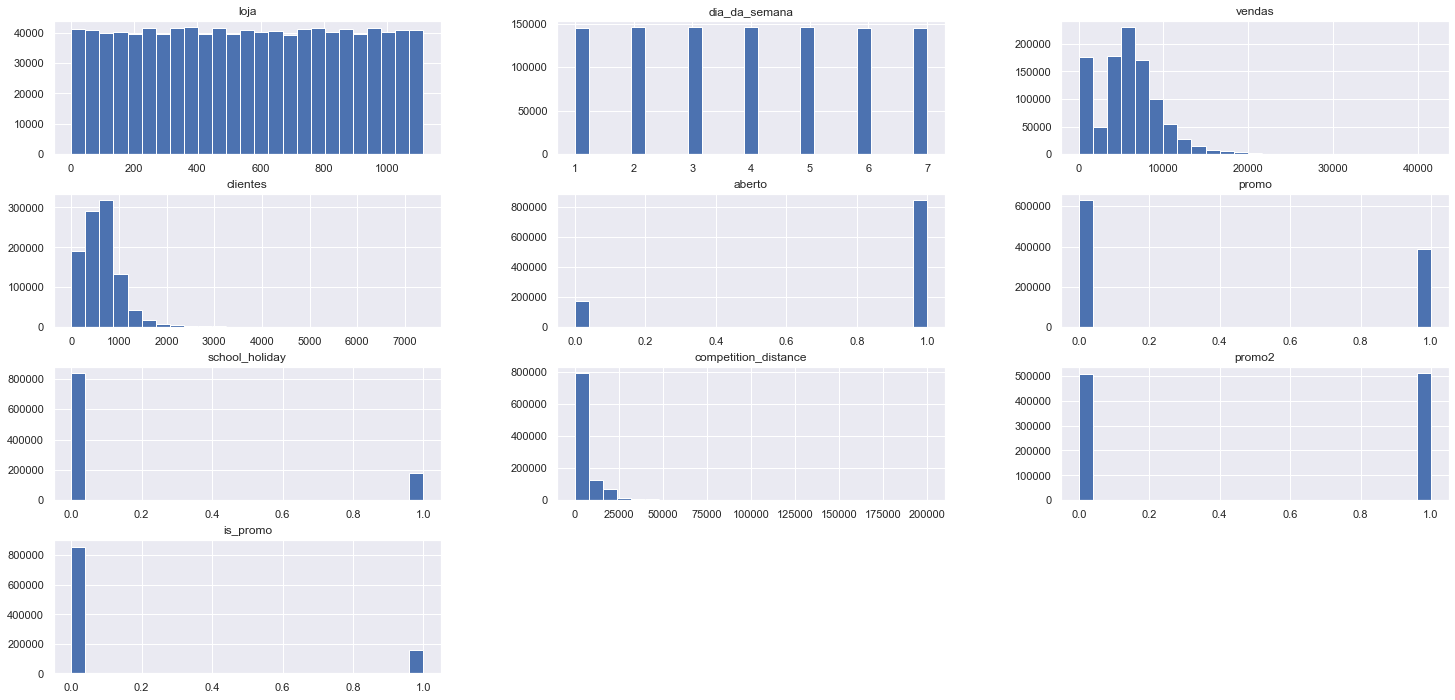

In [31]:
num_attributes.hist( bins = 25 );

### 4.1.3 Categorical variable

In [32]:
df4['variedade'].drop_duplicates()

0         basic
3      extended
258       extra
Name: variedade, dtype: object

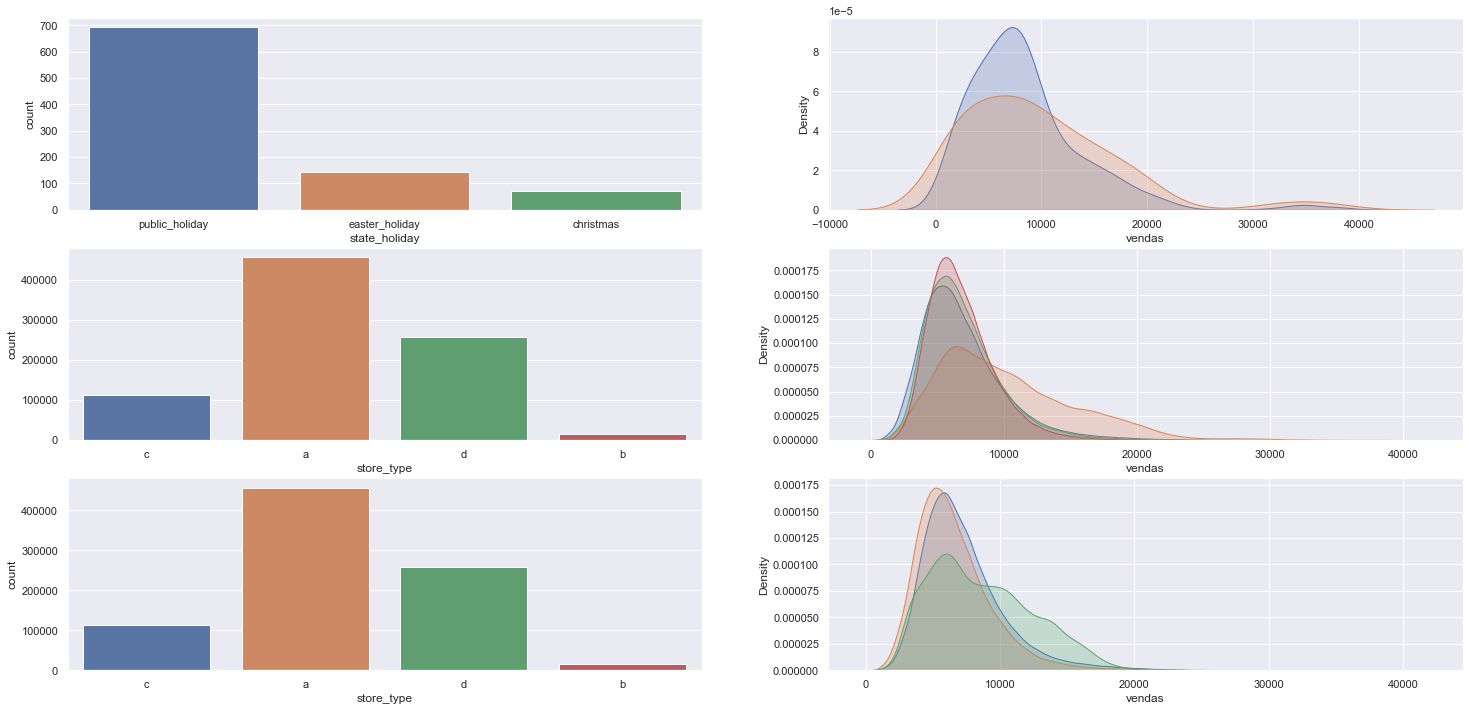

In [33]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] !='regular_day']
sns.countplot( a['state_holiday'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday'] ['vendas'], label = 'public_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday'] ['vendas'], label = 'easter_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas_holiday'] ['vendas'], label = 'christmas_holiday', shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a'] ['vendas'], label = 'a', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b'] ['vendas'], label = 'b', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c'] ['vendas'], label = 'c', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd'] ['vendas'], label = 'd', shade=True );

# varidedade
plt.subplot( 3, 2, 5 )
sns.countplot( df4['store_type'] ); 

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['variedade'] == 'extended'] ['vendas'], label = 'extended', shade=True );
sns.kdeplot( df4[df4['variedade'] == 'basic'] ['vendas'], label = 'basic', shade=True );
sns.kdeplot( df4[df4['variedade'] == 'extra'] ['vendas'], label = 'extra', shade=True );

## 4.2 Análise bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA:** Lojas com maior sortimento vendem MENOS.

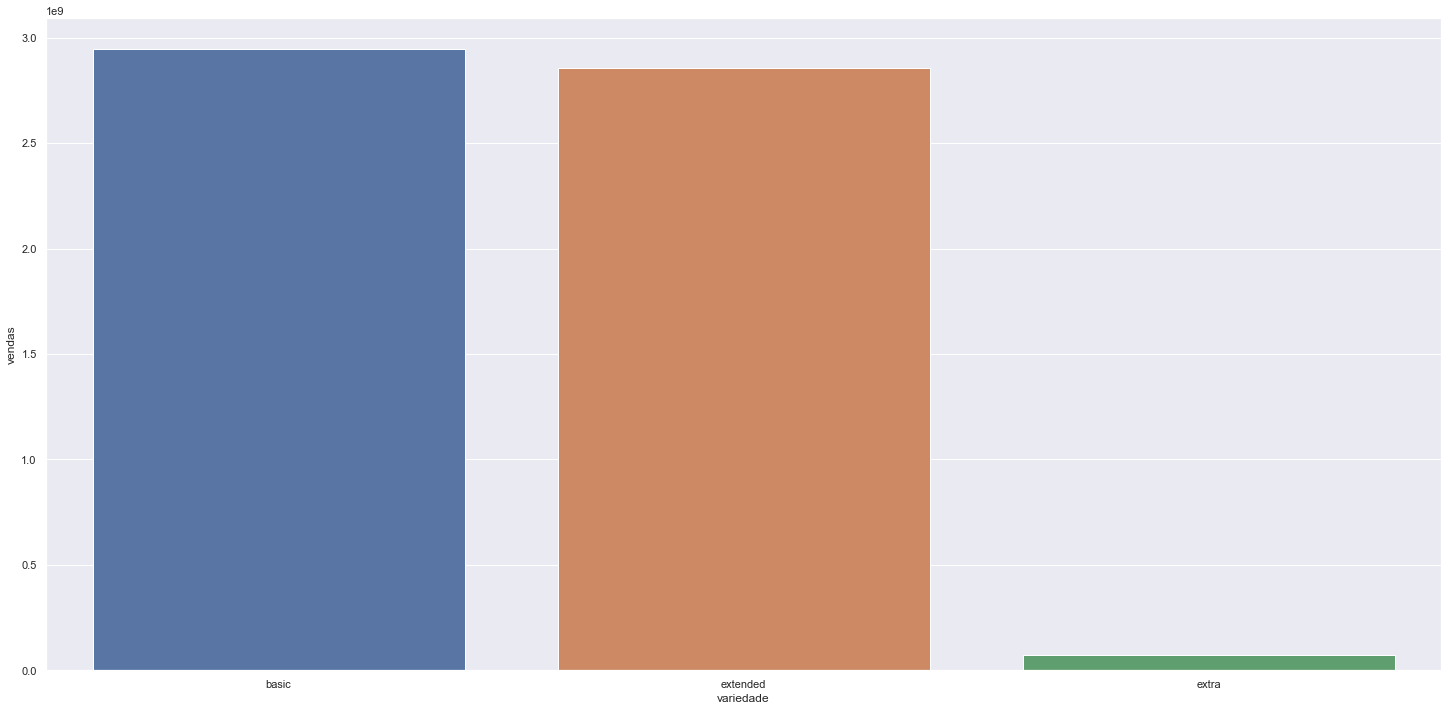

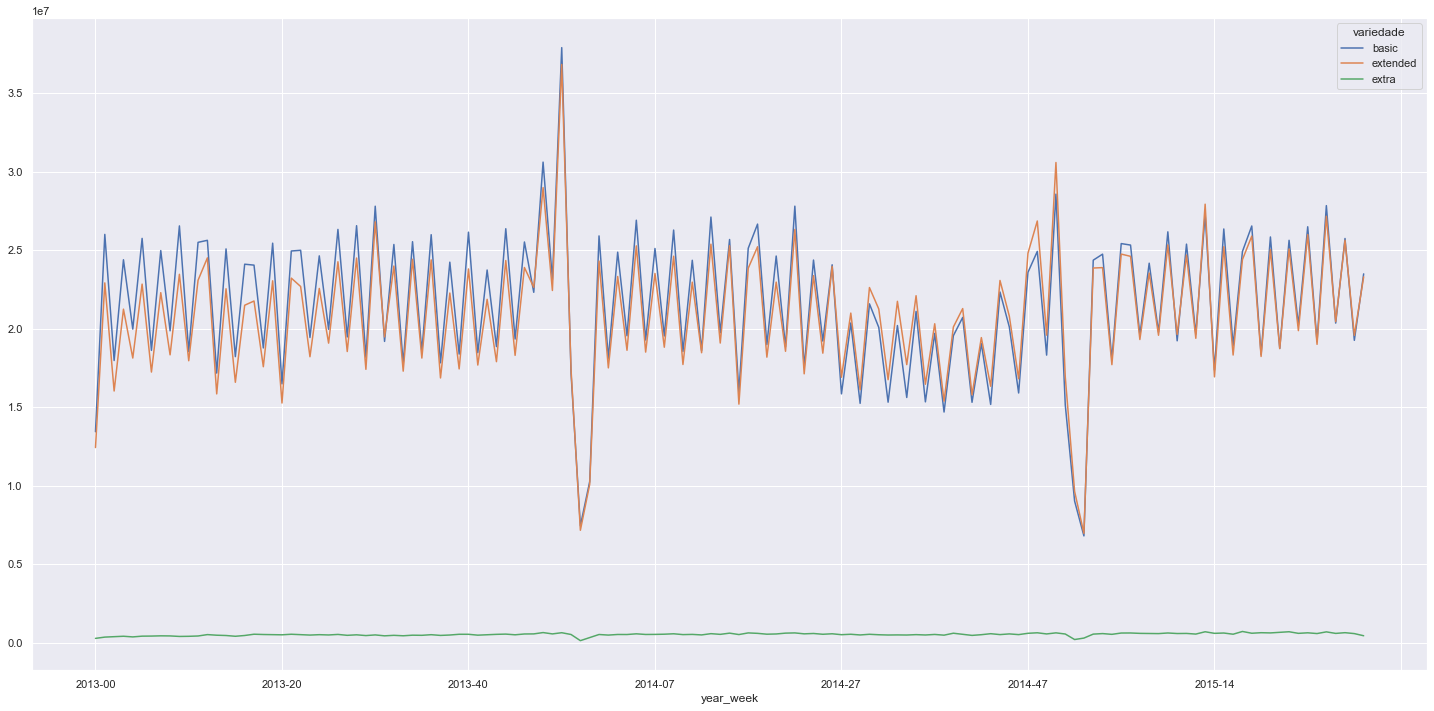

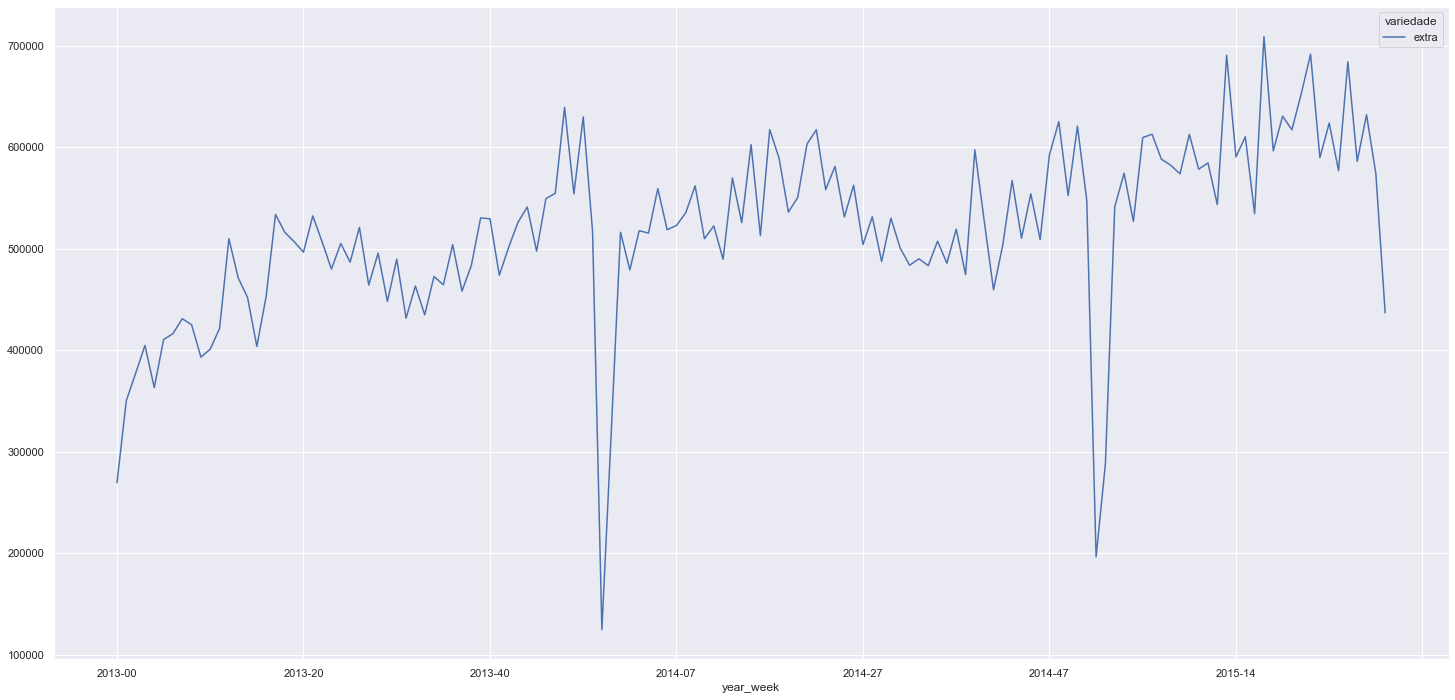

In [34]:
aux1 = df4[['variedade', 'vendas']].groupby('variedade').sum().reset_index()
sns.barplot( x= 'variedade', y= 'vendas', data=aux1 );

aux2 = df4[['year_week', 'variedade', 'vendas']].groupby( ['year_week', 'variedade'] ).sum().reset_index()
aux2.pivot( index= 'year_week', columns= 'variedade', values= 'vendas').plot();

aux3 = aux2[aux2 ['variedade'] == 'extra']
aux3.pivot( index= 'year_week', columns= 'variedade', values= 'vendas').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA:**  Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

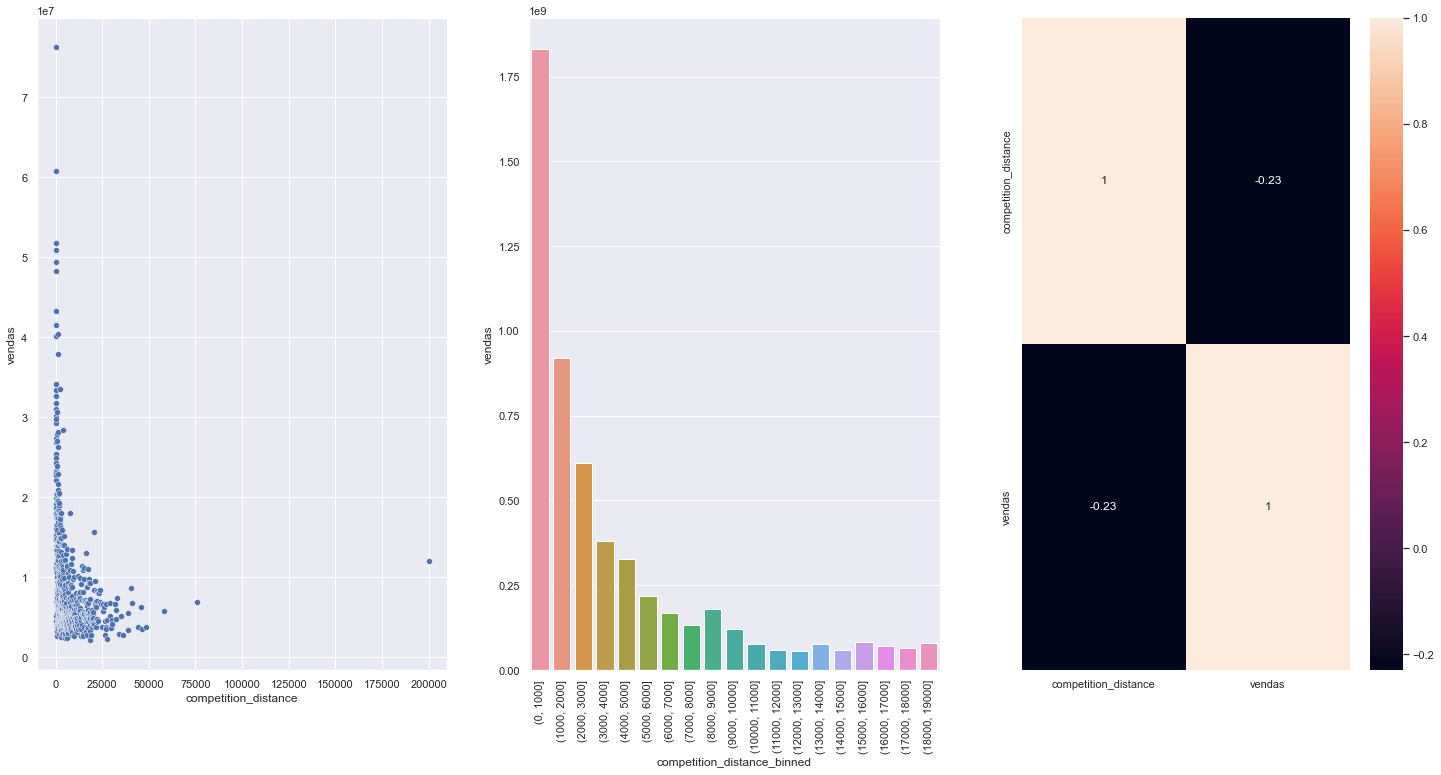

In [35]:
aux1 = df4[['competition_distance', 'vendas']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1);
sns.scatterplot(x= 'competition_distance', y= 'vendas', data=aux1);

plt.subplot( 1, 3, 2);
bins = list ( np.arange(0, 20000, 1000) ) 
aux1['competition_distance_binned' ] = pd.cut(aux1 ['competition_distance'], bins=bins )
aux2 = aux1 [['competition_distance_binned', 'vendas']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned', y= 'vendas', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA:** Lojas com competidores a mais tempo vendem MENOS.

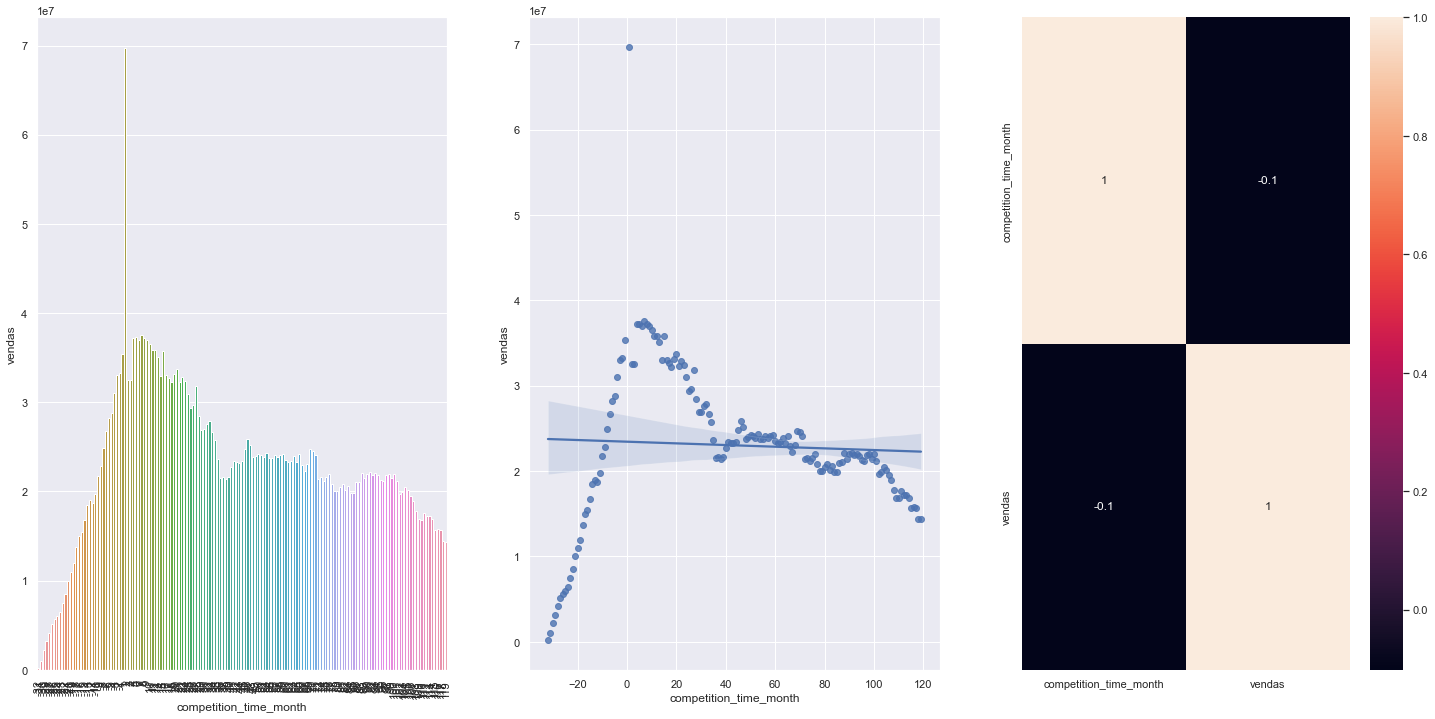

In [36]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'vendas']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y= 'vendas', data= aux2 );
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y= 'vendas', data= aux2 );

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem MENOS.

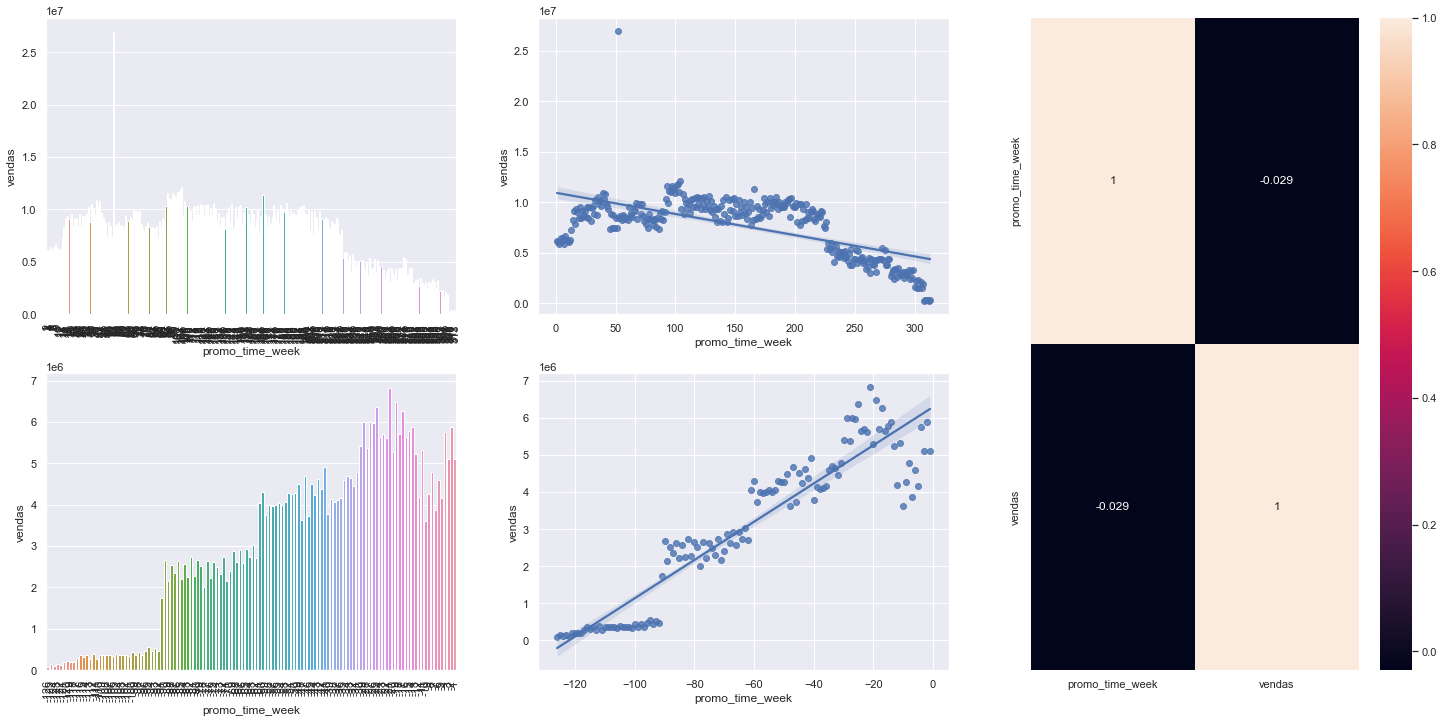

In [37]:
aux1 = df4[['promo_time_week', 'vendas']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot( x= 'promo_time_week', y= 'vendas', data= aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x= 'promo_time_week', y= 'vendas', data= aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot( x= 'promo_time_week', y= 'vendas', data= aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x= 'promo_time_week', y= 'vendas', data= aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr(method= 'pearson'), annot=True );

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

In [38]:
df4[['promo', 'promo2', 'vendas']].groupby( [ 'promo', 'promo2'] ).sum().reset_index()

,promo,promo2,vendas
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


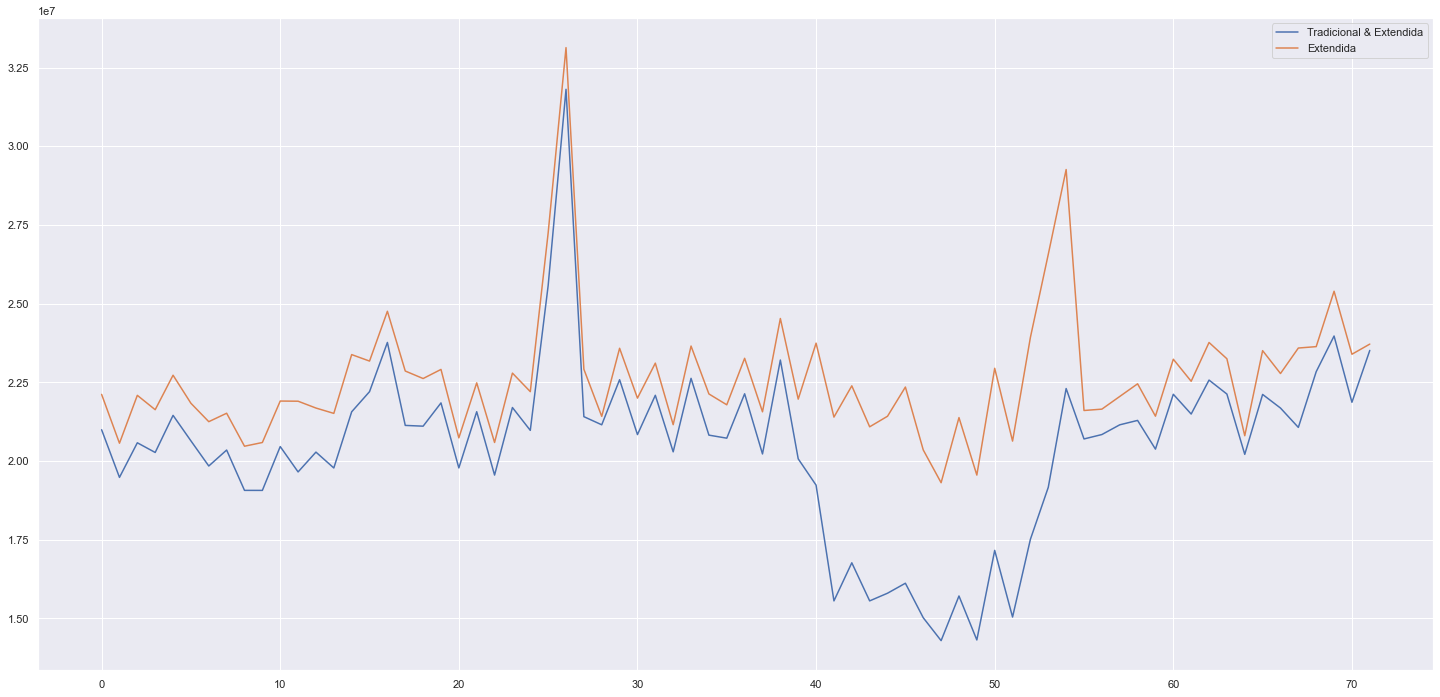

In [39]:
aux1 = df4[ (df4['promo'] == 1 ) & (df4 ['promo2'] == 1)] [['year_week', 'vendas']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ (df4['promo'] == 1 ) & (df4 ['promo2'] == 0)] [['year_week', 'vendas']].groupby( 'year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels = ['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA:** lojas vendem menos durtante o feriado de natal.

In [40]:
df4.head(1)

,loja,dia_da_semana,data,vendas,promo,state_holiday,school_holiday,store_type,variedade,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0


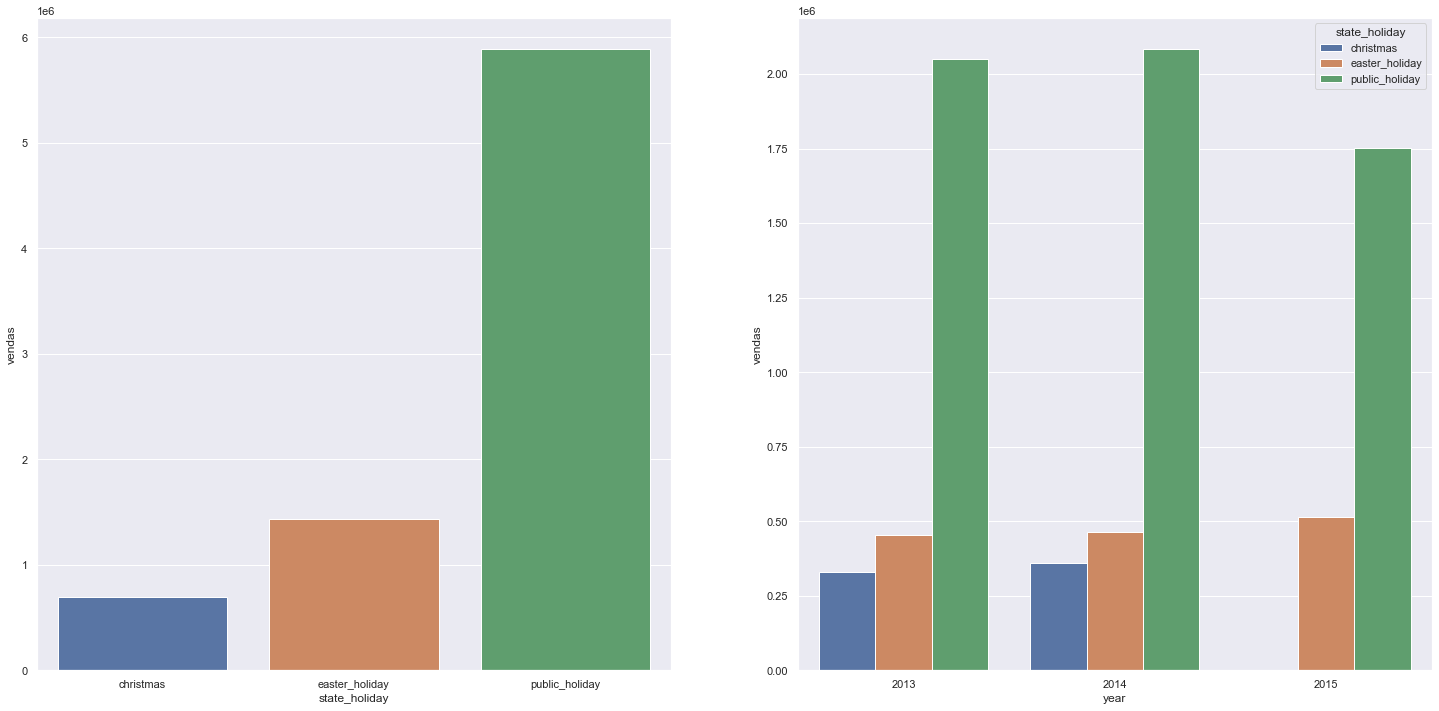

In [41]:
aux = df4[df4['state_holiday']!= 'regular_day']

plt.subplot(1, 2, 1)
aux1 = df4[df4['state_holiday']!= 'regular_day'].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='vendas', data=aux1 );

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'vendas']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='vendas', hue='state_holiday', data=aux2 );

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA:** lojas vendem menos ao longo dos anos

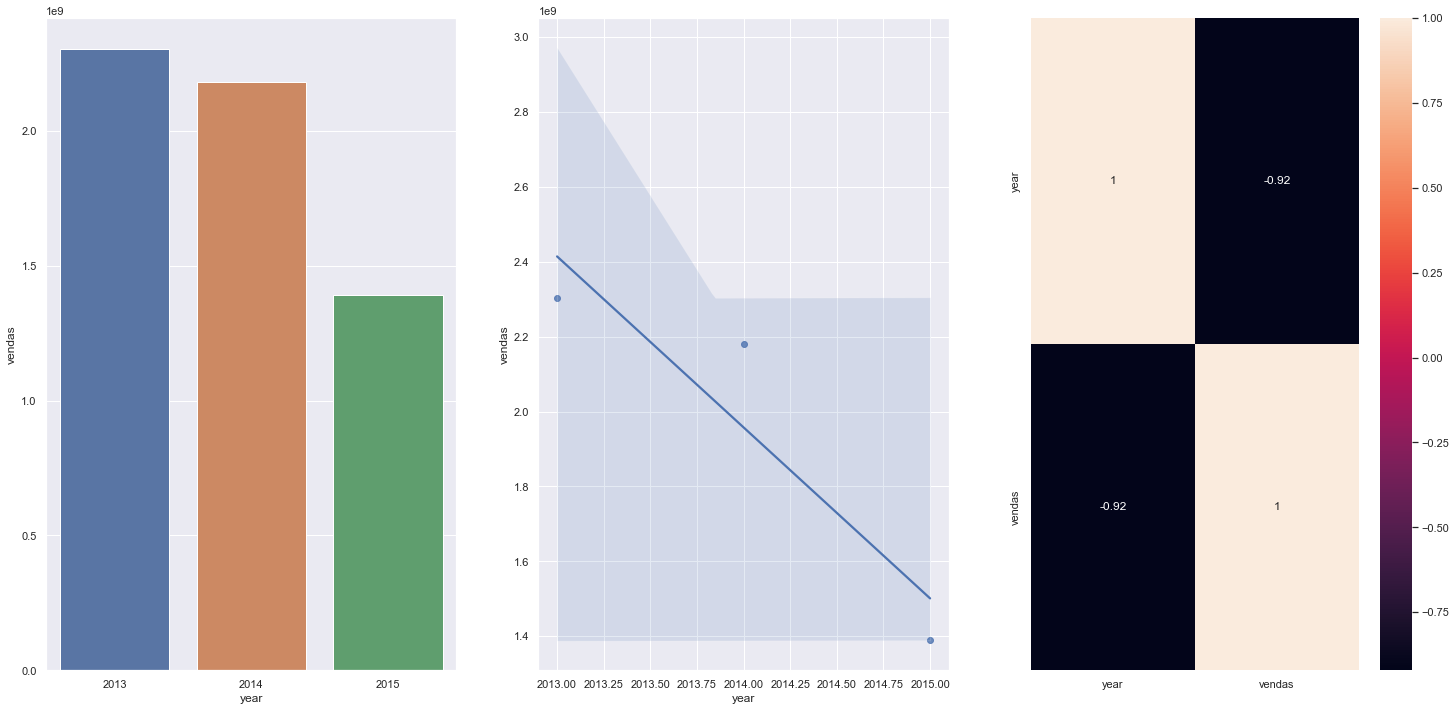

In [42]:
aux1 = df4[['year', 'vendas']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='year', y='vendas', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='vendas', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre.
**FALSA** lojas vendem menos no segundo semestre do ano.

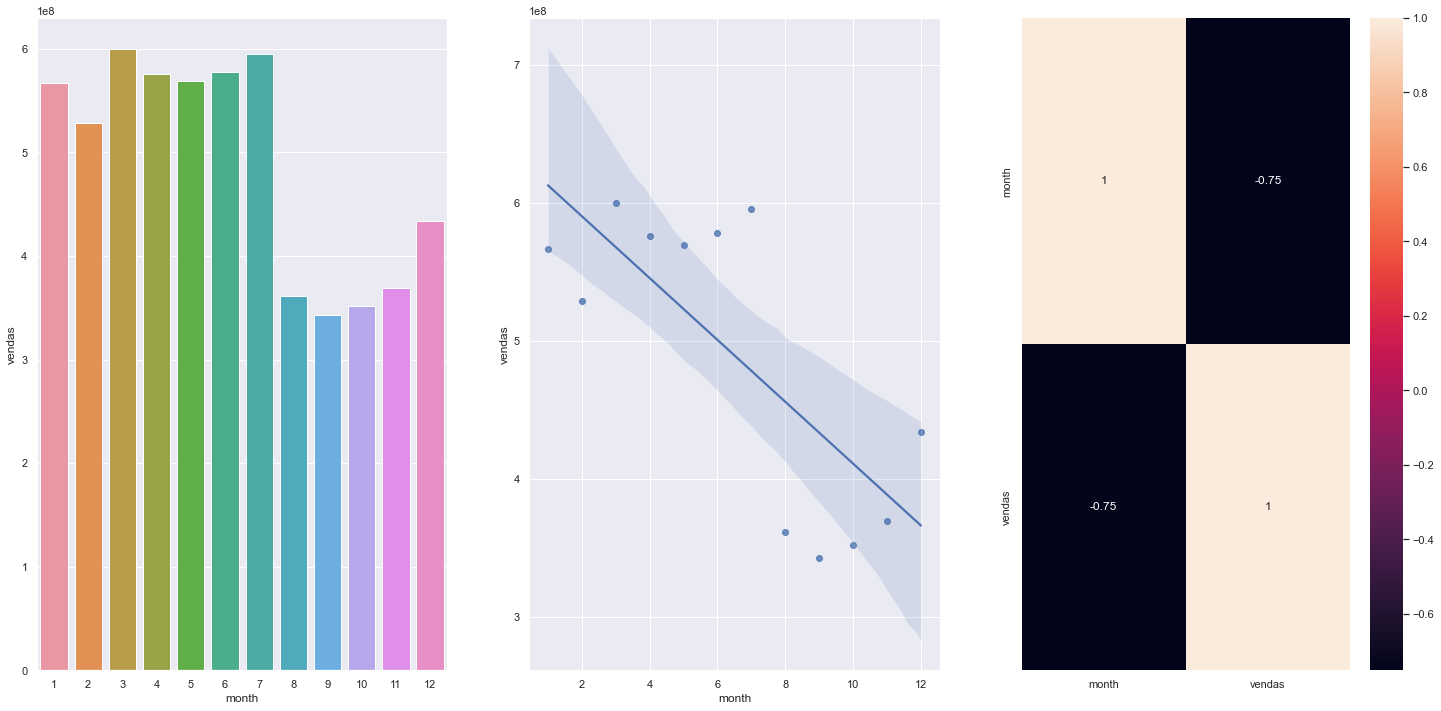

In [43]:
aux1 = df4[['month', 'vendas']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='month', y='vendas', data= aux1);

plt.subplot( 1, 3, 2)
sns.regplot(x='month', y='vendas', data= aux1);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr(method= 'pearson' ), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA:** lojas deveriam vender mais depois do dia 10.

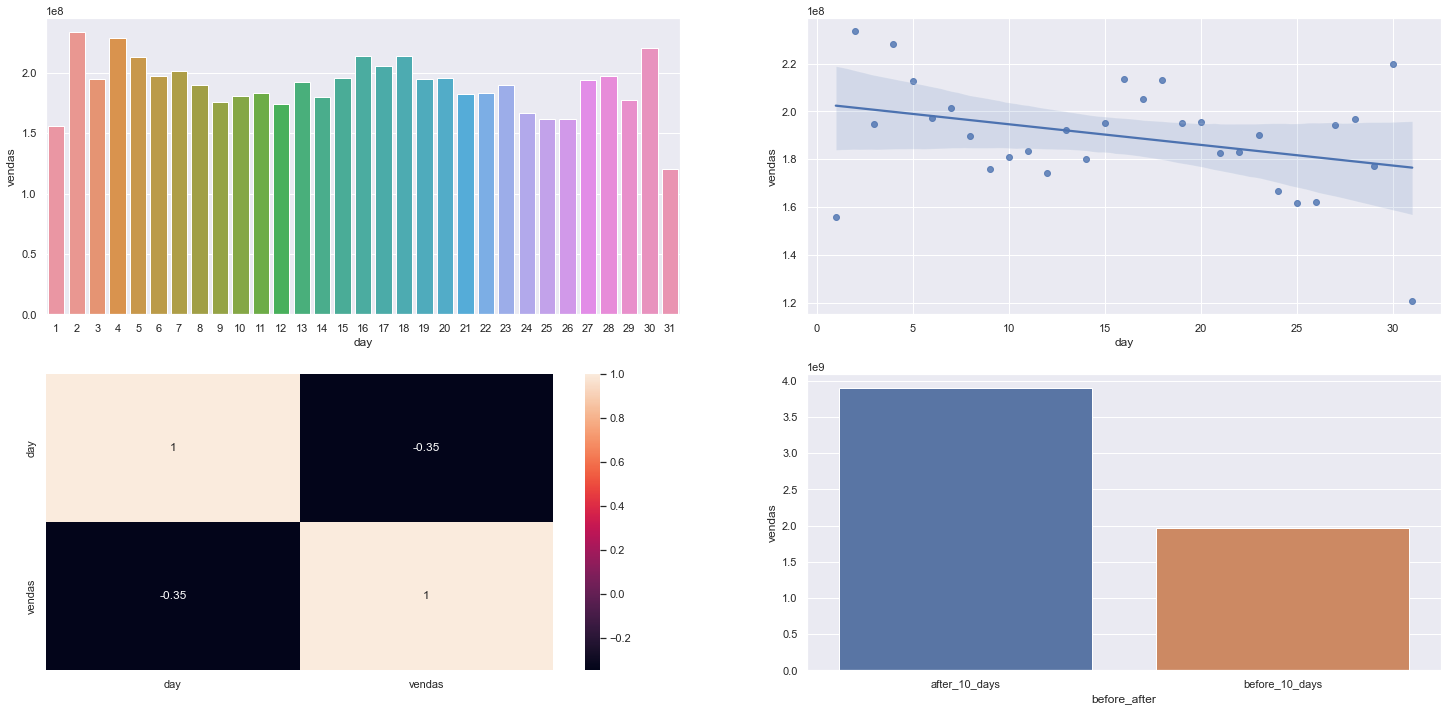

In [44]:
aux1 = df4[['day', 'vendas']].groupby('day').sum().reset_index()

plt.subplot( 2 , 2, 1 )
sns.barplot( x='day', y='vendas', data=aux1 );

plt.subplot( 2 , 2, 2 )
sns.regplot( x='day', y='vendas', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'vendas']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='vendas', data=aux2 );

### H11. Lojas deveriam vender menos finais de semana.
**VERDADEIRA:** lojas vendem menos nos finais de semana.

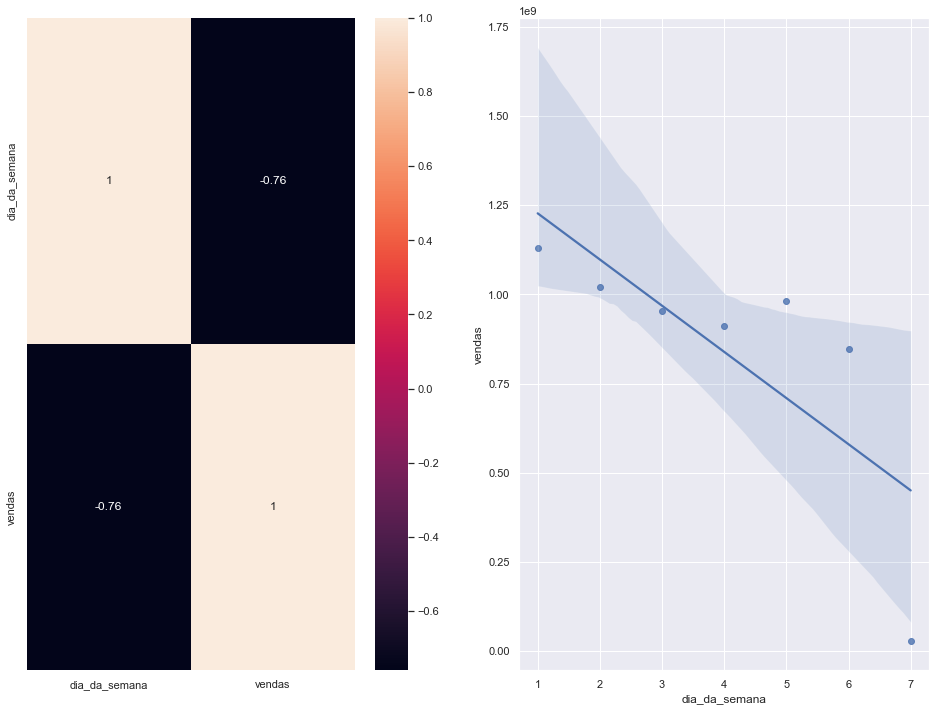

In [45]:
aux1 = df4[['dia_da_semana', 'vendas']].groupby('dia_da_semana').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='dia_da_semana', y='vendas', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='dia_da_semana', y='vendas', data=aux1 );

plt.subplot(1, 3, 1)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA,** exceto no mês de agosto.

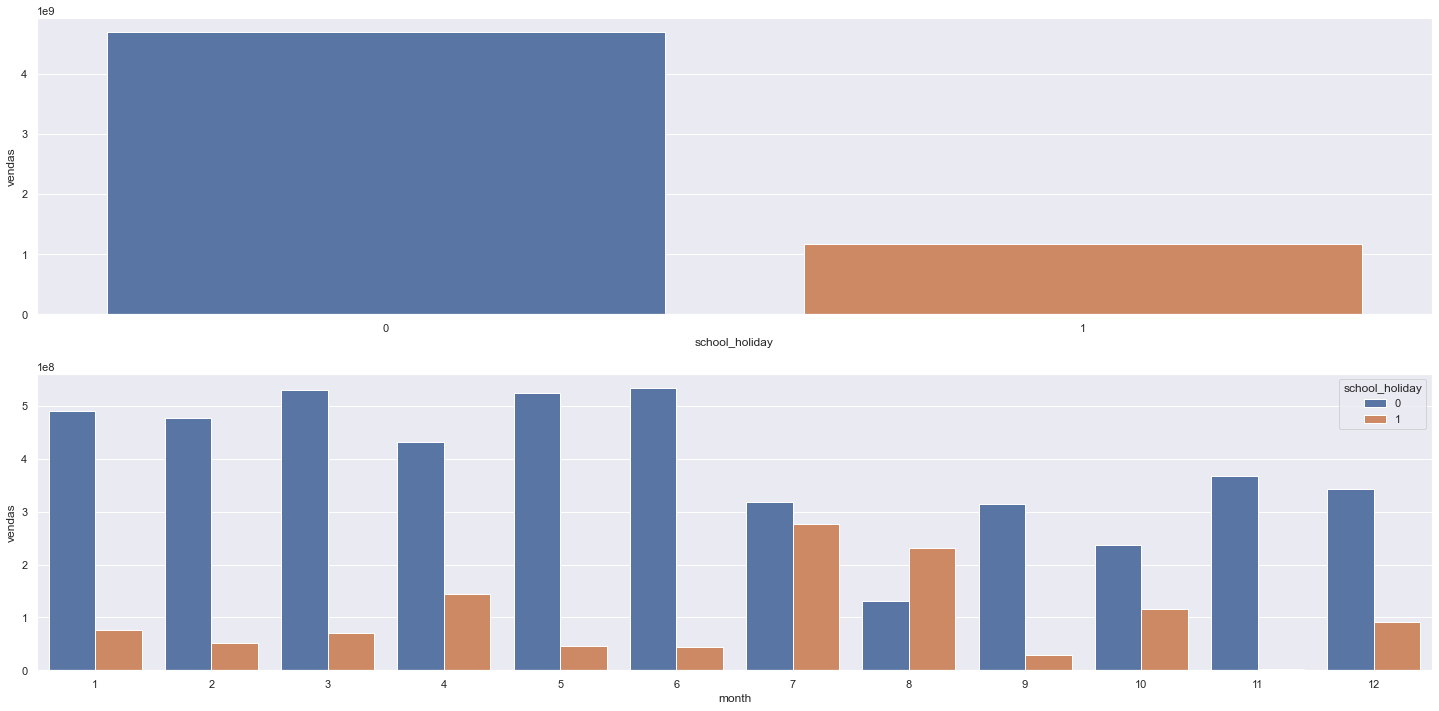

In [46]:
aux1 = df4[['school_holiday', 'vendas']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='vendas', data=aux1);

aux2 = df4[['month', 'school_holiday', 'vendas']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='vendas', hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipoteses

In [47]:
from tabulate import tabulate

In [48]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise multivariada

### 4.3.1. Numerical Attributes

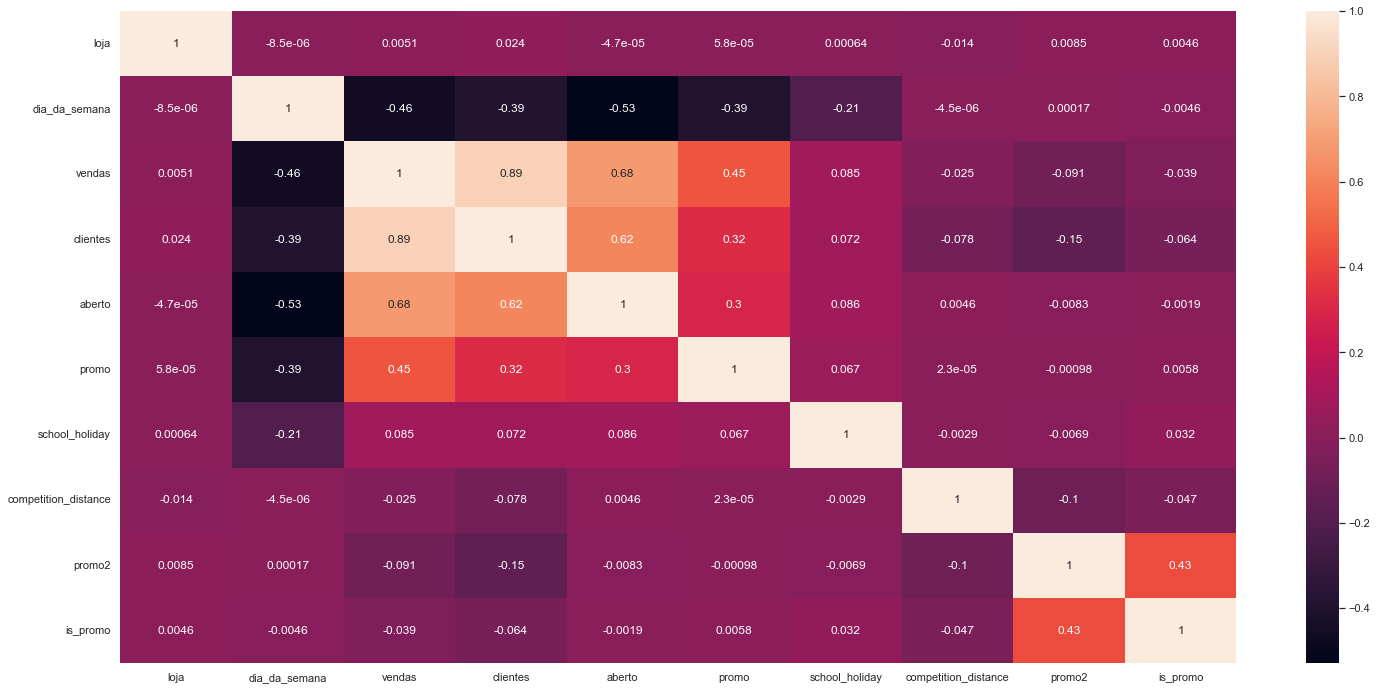

In [49]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

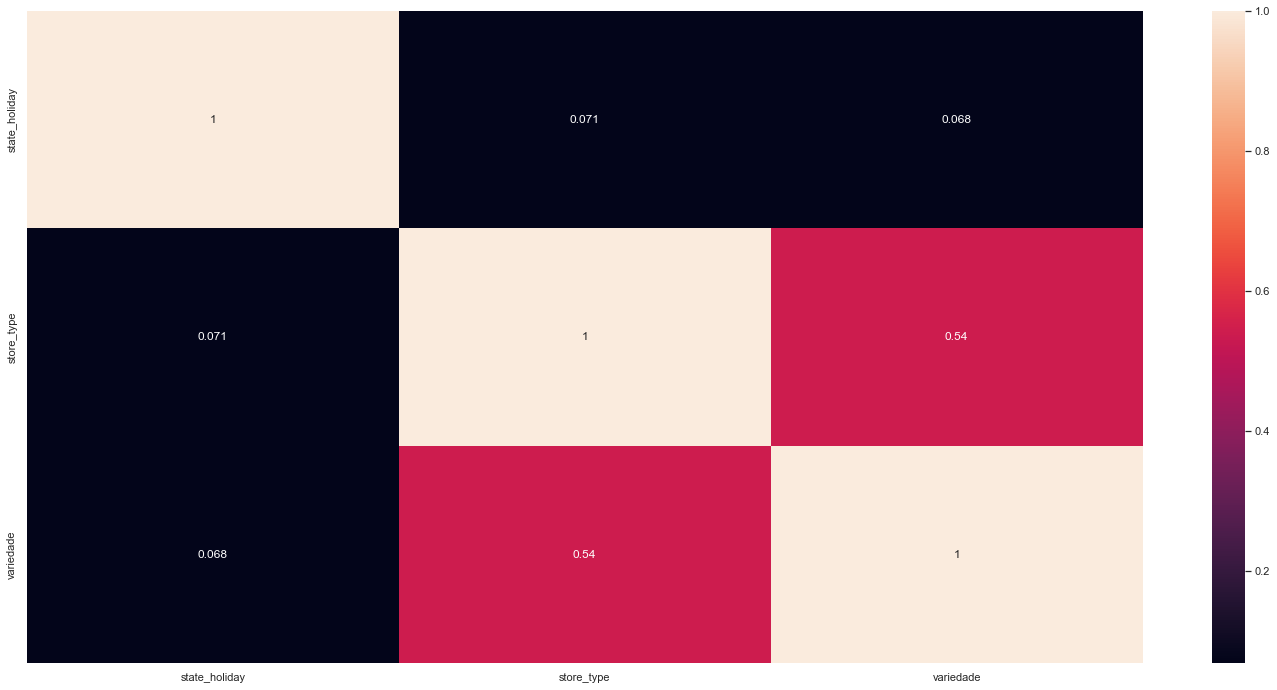

In [50]:
 # only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['variedade'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['variedade'] )
a7 = cramer_v( a['variedade'], a['state_holiday'] )
a8 = cramer_v( a['variedade'], a['store_type'] )
a9 = cramer_v( a['variedade'], a['variedade'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'variedade': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0.  DATA PREPARATION

In [51]:
df5 = df4.copy()

## 5.1. Normalizaçao

## 5.2. Rescalling

In [52]:
rs = RobustScaler()
mns = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mns.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mns.fit_transform( df5[['year']].values )

In [53]:
# month
# day
# Week of year
# day of week

## 5.3. Transformação

### 5.3.1. Encoding

In [54]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies ( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# variedade - Ordinal Encoding
variedade_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['variedade'] = df5['variedade'].map(variedade_dict)

### 5.3.2. Response Variable Transformation

In [55]:
df5['vendas'] = np.log1p(df5['vendas'])

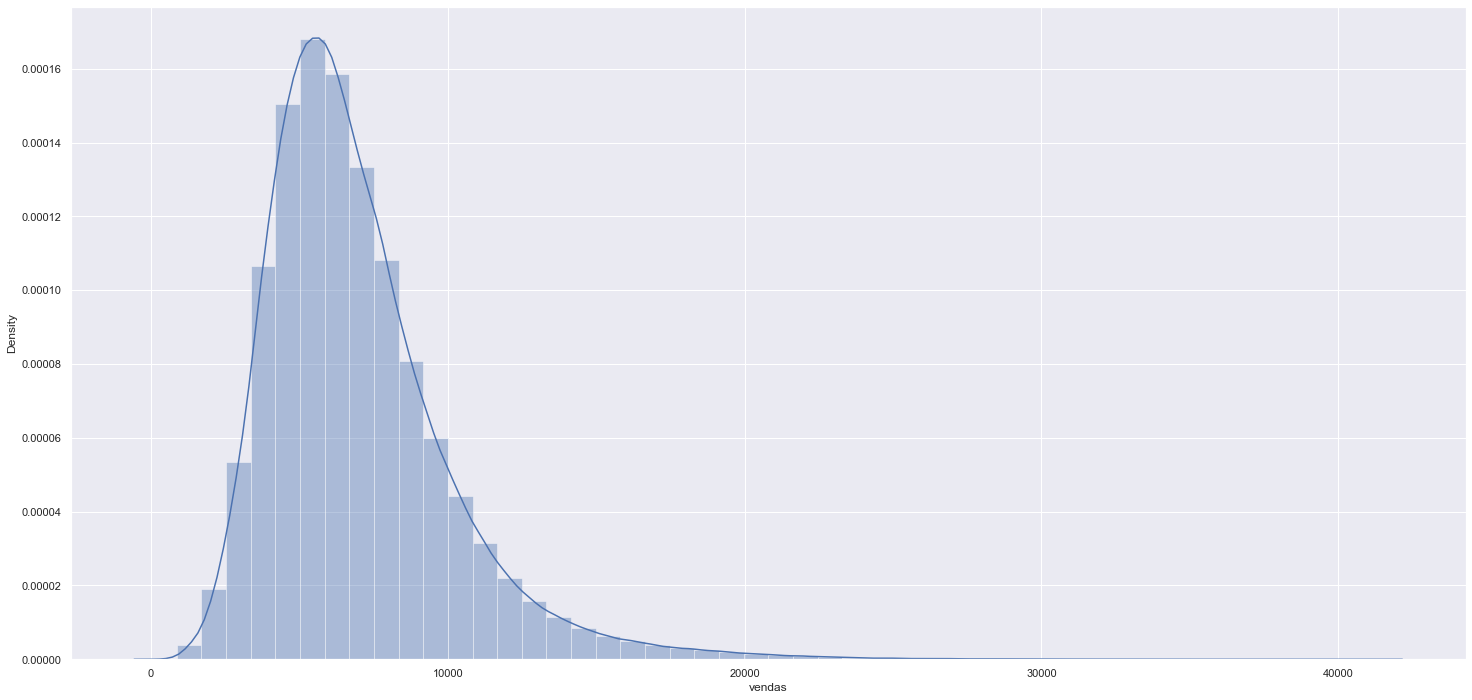

In [56]:
sns.distplot(df4['vendas']);

### 5.3.3 Nature Transformation

In [57]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2. * np.pi/30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/52)))

# dia_da_semana
df5['dia_da_semana_sin'] = df5['dia_da_semana'].apply( lambda x: np.sin(x * (2. * np.pi/7)))
df5['dia_da_semana_cos'] = df5['dia_da_semana'].apply( lambda x: np.cos(x * (2. * np.pi/7)))

# 6.0. FEATURE SELECTION

In [58]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [59]:
cols_drop = ['week_of_year', 'day', 'month', 'dia_da_semana', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [60]:
# trainig dataset
X_train = df6[df6['data'] < '2015-06-19']
y_train = X_train['vendas'] 

# test dataset
X_test = df6[df6['data'] >= '2015-06-19']
y_test = X_test['vendas'] 

print( 'Training Mix Data: {}'.format( X_train['data'].min() ) )
print( 'Training Max Data: {}'.format( X_train['data'].max() ) )

print( '\nTest Mix Data: {}'.format( X_test['data'].min() ) )
print( 'Test Max Data: {}'.format( X_test['data'].max() ) )

Training Mix Data: 2013-01-01 00:00:00
Training Max Data: 2015-06-18 00:00:00

Test Mix Data: 2015-06-19 00:00:00
Test Max Data: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [61]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['data', 'vendas'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = x_train.drop( ['data', 'vendas'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [63]:
cols_selected_boruta = [
'loja',
'promo',
'store_type',
'variedade',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'dia_da_semana_sin',
'dia_da_semana_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['data', 'vendas']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MODELOS DE MACHINE LEARNING

In [64]:
df7 = df6.copy()

In [65]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [66]:
aux1 = x_test.copy()
aux1['vendas'] = y_test.copy()

# prediction
aux2 = aux1[['loja', 'vendas']].groupby( 'loja' ).mean().reset_index().rename(columns={'vendas': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='loja' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [67]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3. Linear Regression Regularized Model - Lasso

In [68]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.2. Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [70]:
'''
# model
 rf = RandomForestRegressor ( n_estimators=100, n_jobs=1, random_state=42 ).fit( x_train, y_train )
 
 # prediction
 yhat_rf = rf.predict( x_test )
 
 # performance
 rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
 rf_result
 
 '''

"\n# model\n rf = RandomForestRegressor ( n_estimators=100, n_jobs=1, random_state=42 ).fit( x_train, y_train )\n \n # prediction\n yhat_rf = rf.predict( x_test )\n \n # performance\n rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )\n rf_result\n \n "

### 7.4.1. Random Forest Regressor - Cross Validation

In [71]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5. XGBoost Regressor

In [72]:
'''
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

'''

"\n# model\nmodel_xgb = xgb.XGBRegressor( objective='reg:squarederror',\n                              n_estimators=100,\n                              eta=0.01,\n                              max_depth=10,\n                              subsample=0.7,\n                              colsample_bytee=0.9 ).fit( x_train, y_train )\n\n# prediction\nyhat_xgb = model_xgb.predict( x_test )\n\n# performance\nxgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )\nxgb_result\n\n"

### 7.5. XGBoost Regressor - Cross Validation

In [73]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv

## 7.6. Compare Model's Performance

In [74]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

# 8.0.  HYPERPARAMETER FINE TUNING


In [75]:
df8 = df7.copy()

## 8.1. Random Search 

In [76]:
'''
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 5

'''

"\nparam = {\n        'n_estimators': [1500, 1700, 2500, 3000, 3500],\n        'eta': [0.01, 0.03],\n        'max_depth': [3, 5, 9],\n        'subsample': [0.1, 0.5, 0.7],\n        'colsample_bytree': [0.3, 0.7, 0.9],\n        'min_child_weight': [3, 8, 15]\n        }\nMAX_EVAL = 5\n\n"

In [77]:
'''
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
     # choose values for parameters randomly
     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
     print( hp )

     # model
     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=hp['n_estimators'],
                                    eta=hp['eta'],
                                    max_depth=hp['max_depth'],
                                    subsample=hp['subsample'],
                                    colsample_bytee=hp['colsample_bytree'],
                                    min_child_weight=hp['min_child_weight'] )

     # performance
     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
     final_result = pd.concat( [final_result, result] )

final_result

'''

"\nfinal_result = pd.DataFrame()\n\nfor i in range( MAX_EVAL ):\n     # choose values for parameters randomly\n     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }\n     print( hp )\n\n     # model\n     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',\n                                    n_estimators=hp['n_estimators'],\n                                    eta=hp['eta'],\n                                    max_depth=hp['max_depth'],\n                                    subsample=hp['subsample'],\n                                    colsample_bytee=hp['colsample_bytree'],\n                                    min_child_weight=hp['min_child_weight'] )\n\n     # performance\n     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )\n     final_result = pd.concat( [final_result, result] )\n\nfinal_result\n\n"

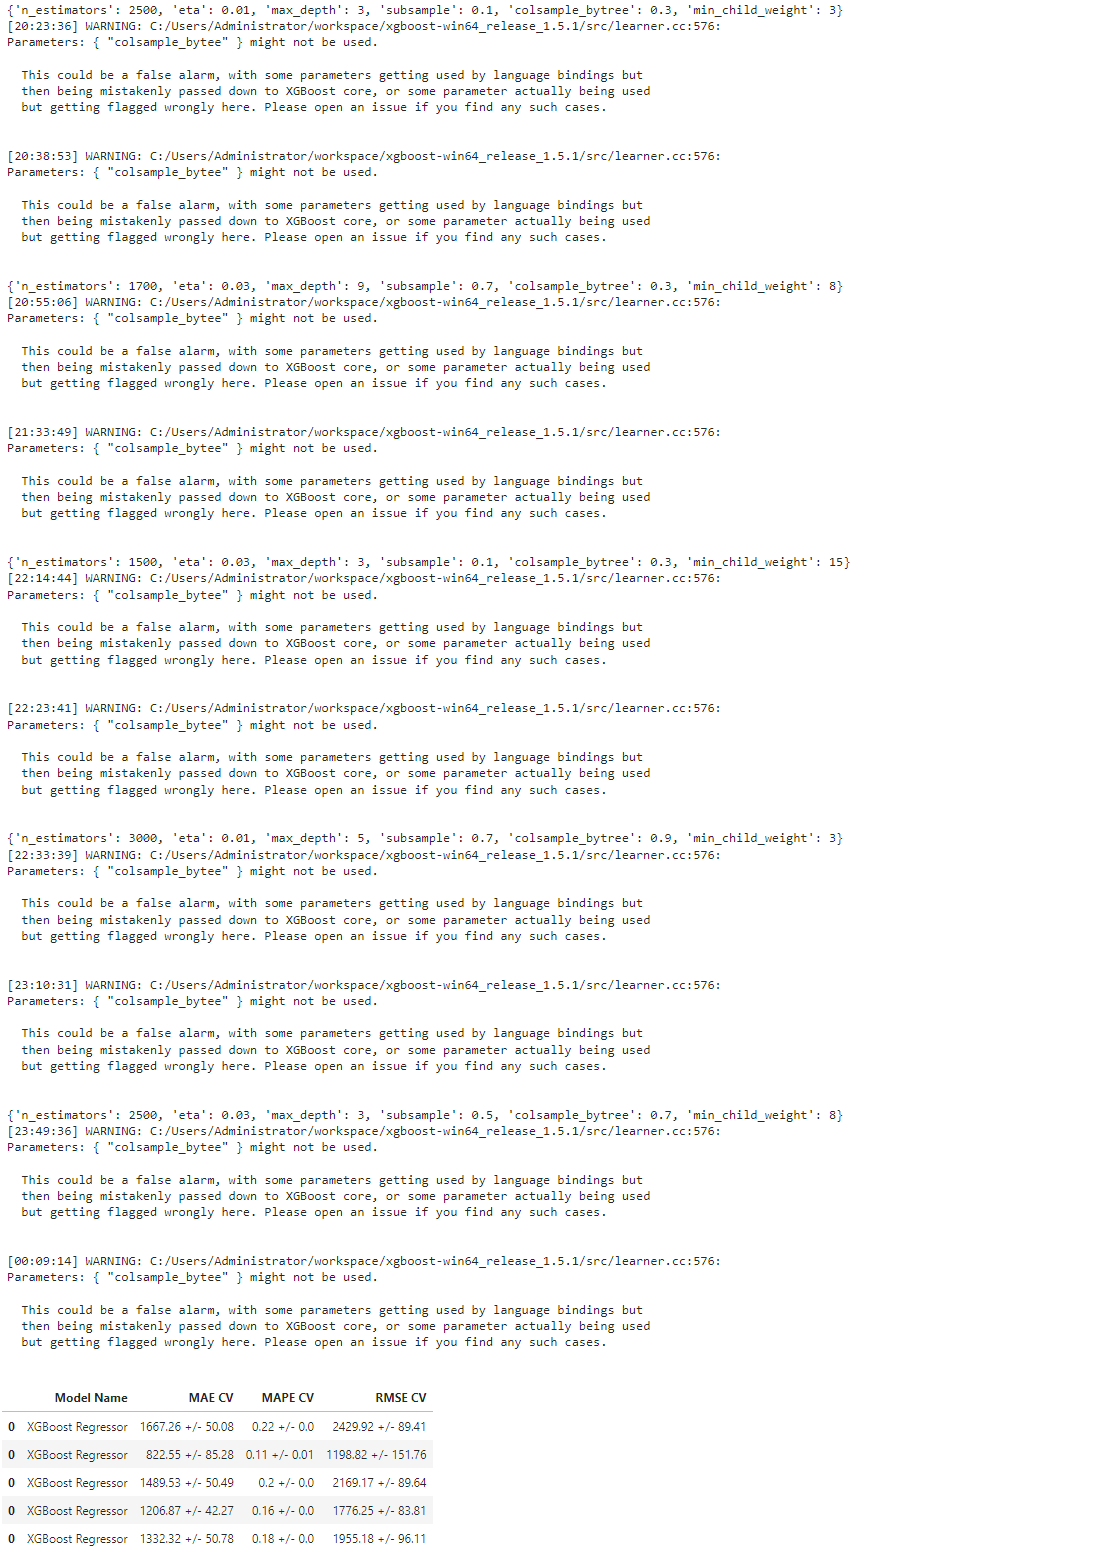

In [78]:
Image('../Img/random_search.png')

## 8.2. Final Model

In [79]:

param_tuned = { 
'n_estimators': 3000,
'eta': 0.03,
'max_depth': 5,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
 }
 


In [81]:

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],

colsample_bytee=param_tuned['colsample_bytree'],

min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned


[17:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056876,0.114527,1088.444637


# 9.0. INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [83]:
df9 = df8.copy()

In [84]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['vendas'] = np.expm1( df9['vendas'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance

In [88]:
# sum of predictions
df91 = df9[['loja', 'predictions']].groupby( 'loja' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['loja', 'vendas', 'predictions']].groupby( 'loja' ).apply(lambda x: mean_absolute_error( x['vendas'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['loja', 'vendas', 'predictions']].groupby( 'loja' ).apply(lambda x: mean_absolute_percentage_error( x['vendas'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='loja' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='loja' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['loja', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [89]:
df92.sort_values( 'MAPE', ascending=False ).head()

,loja,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106846.78125,103486.930253,110206.632247,3359.850997,0.588673
908,909,228641.00000,220905.138587,236376.861413,7735.861413,0.515674
169,170,207572.87500,206069.607937,209076.142063,1503.267063,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873654,374814.563846,4288.845096,0.295612


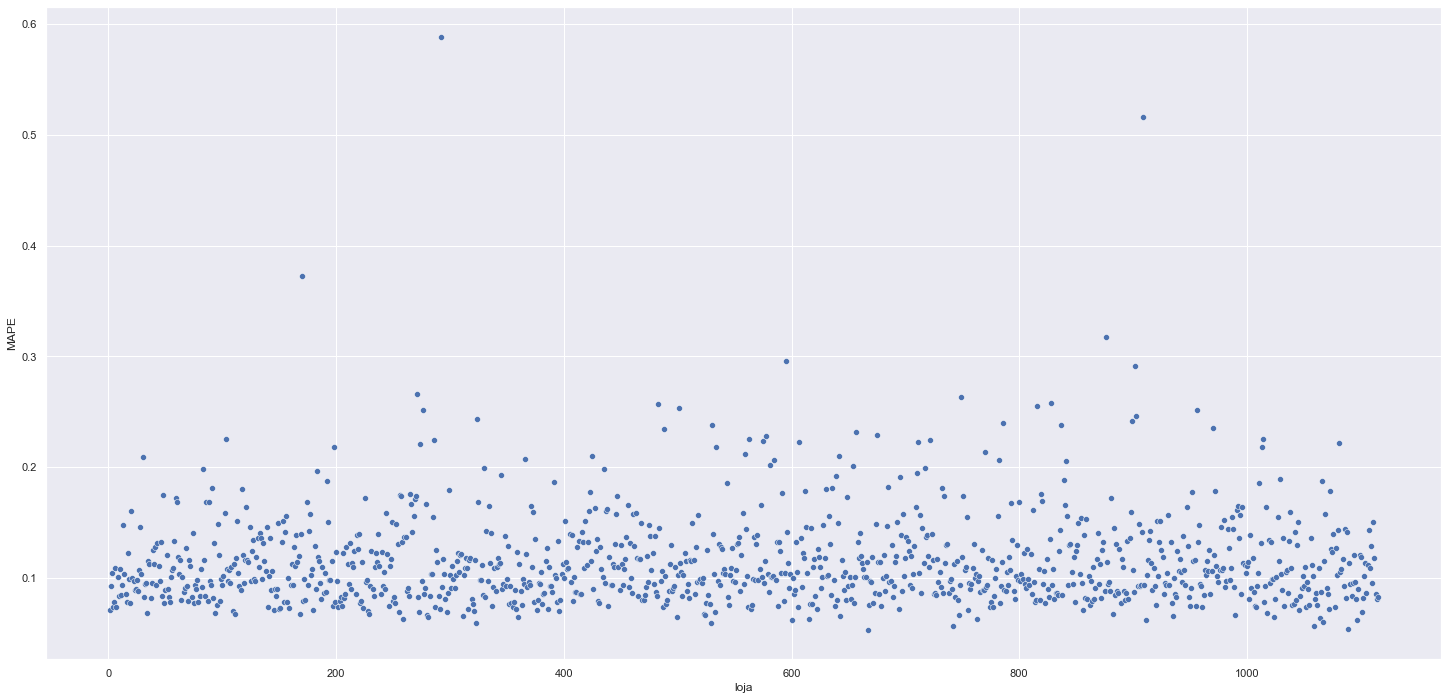

In [90]:
 sns.scatterplot( x='loja', y='MAPE', data=df92 );

## 9.2. Total Performance

In [91]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$287,260,416.00"
1,worst_scenario,"R$286,409,667.53"
2,best_scenario,"R$288,111,145.53"


## 9.3. Machine Learning Performance

In [92]:
df9['error'] = df9['vendas'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['vendas']

<AxesSubplot:xlabel='predictions', ylabel='error'>

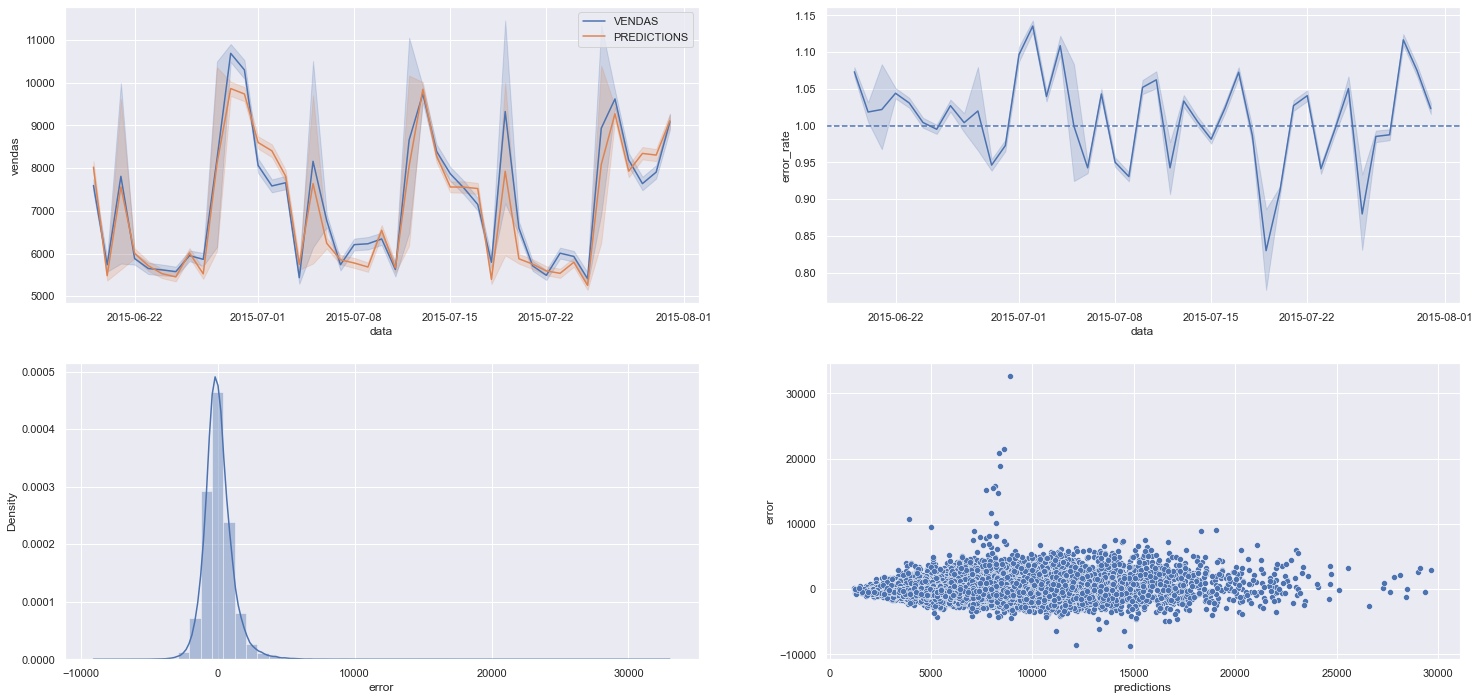

In [93]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='data', y='vendas', data=df9, label='VENDAS' )
sns.lineplot( x='data', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='data', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )